# Introduction to Q-Learning
<hr>
Author: Sahil Johari (http://www.sahiljohari.com/)

In this notebook, I am going to try creating Q-learning models from simple to complex levels to solve certain standard problems pre-existing on https://gym.openai.com

Let's get started!

# Level 1: A simple model

Reinforcement learning, explained simply, is a computational approach where an agent interacts with an environment by taking actions in which it tries to maximize an accumulated reward. Here is a simple graph, which I will be referring to often:

![Q_learning.PNG](attachment:Q_learning.PNG)

An agent in a current state (St) takes an action (At) to which the environment reacts and responds, returning a new state(St+1) and reward (Rt+1) to the agent. Given the updated state and reward, the agent chooses the next action, and the loop repeats until an environment is solved or terminated.

In [1]:
import gym
from gym import envs

import numpy as np
import time
from IPython.display import display, clear_output

In [2]:
env = gym.make('Taxi-v2')

In [3]:
# The starting state which is random
env.reset()

254

In [4]:
# Gives all the possible states in this environment
env.observation_space.n

500

In [5]:
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
# Gives the number of actions available to our agent
env.action_space.n

6

The six possible actions are: down (0), up (1), right (2), left (3), pick-up (4), and drop-off (5).

In [7]:
# Overriding the current state to 114 for learning purpose
env.env.s = 114
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [8]:
env.step(1)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


So, we moved 'up' by taking step (1) which corresponds to "up" action.

In [9]:
print(env.step(1))

(14, -1, False, {'prob': 1.0})


These values are (state, reward, done, info)

Now that we have explored the basics, let's start again with a fresh code.

In [10]:
state = env.reset()
counter = 0
reward = None

while reward != 20:
    state, reward, done, info = env.step(env.action_space.sample())
    counter += 1

print(counter)

6013


In the above code, we saw that it took 1870 steps for our agent to reach the goal (or achieve a reward of 20, which is the goal). This approach is a _random policy approach_ in which the agent is trying out random actions until it gets the maximum reward.

Let's try to have the algorithm remember its actions and their associated rewards. In this case, the algorithm’s memory is going to be a *Q action value table*.

To manage this Q table, we will use a NumPy array. The size of this table will be the number of states (500) by the number of possible actions (6).

In [11]:
Q = np.zeros([env.observation_space.n, env.action_space.n])

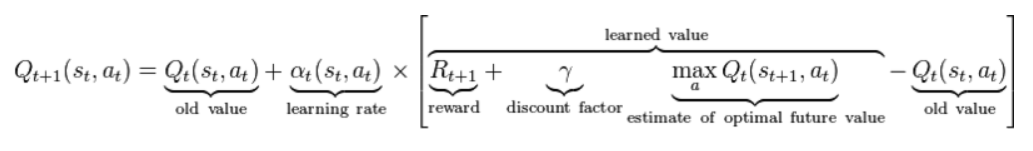

Over multiple episodes of trying to solve the problem, we will be updating our Q values using the Bellman equation shown above, slowly improving our algorithm’s efficiency and performance. We will also want to track our total accumulated reward for each episode, which we will define as **G**.

In [12]:
G = 0
alpha = 0.618 #learning rate

In [13]:
# Now, a very basic Q-learning algorithm

for episode in range(8000):
    done = False
    reward = 0
    state = env.reset()
    
    while not done:
        action = np.argmax(Q[state]) #1
        state1, reward, done, info = env.step(action) #2
        Q[state,action] += alpha * (reward + np.max(Q[state1]) - Q[state,action]) #3
        G += reward
        state = state1
    if episode % 100 == 0:
        display(print('Episode {} State: {} Total Reward: {}'.format(episode,state, G)))
        display(env.render())
        time.sleep(0.1)
        clear_output(wait=True)

Episode 7900 State: 479 Total Reward: 33080


None

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


None

-First (#1): The agent starts by choosing an action with the highest Q value for the current state using argmax. Argmax will return the index/action with the highest value for that state. Initially, our Q table will be all zeros. But, after every step, the Q values for state-action pairs will be updated.

-Second (#2): The agent then takes action and we store the future state as state2 (St+1). This will allow the agent to compare the previous state to the new state.

-Third (#3): We update the state-action pair (St , At) for Q using the reward, and the max Q value for state2 (St+1). This update is done using the action value formula (based upon the Bellman equation) and allows state-action pairs to be updated in a recursive fashion (based on future values). Note that we still do not have a discount factor included in this model.

<hr>
# Level 2: Life is all about Balance

In this level, I am going to try out a new environment from the Gym toolkit called _CartPole_.

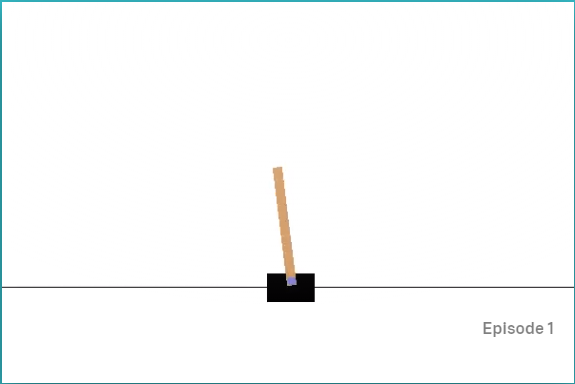

The idea is to teach our agent to balance a pole placed on a cart. Let's dive into it and see if I can create an agent based on what I've learnt before.

Things I need to write the code:
* Q-table
* learning rate
* discount factor
* reward
* action
* state
* epsilon
* observation time-step

In [14]:
# Code adapted from: https://github.com/llSourcell/deep_q_learning/blob/master/03_PlayingAgent.ipynb
import matplotlib.pyplot as plt
from IPython import display

from sklearn import metrics as mt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, Adagrad
from collections import deque            # For storing moves 

import numpy as np
import gym

import random     # For sampling batches from the observations
import timeit

import warnings
warnings.simplefilter("ignore")

C:\Users\sahil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [16]:
env.observation_space.shape

(4,)

In [17]:
# Helper function to render output using matplotlib
def show_state(env, episode, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s Episode: %d | Step: %d %s" % (env.spec.id, episode, step, info))
    plt.axis('off')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [18]:
# Create network. Input is two consecutive game states, output is Q-values of the possible moves.
model = Sequential()
model.add(Dense(200, input_shape=(2,) + env.observation_space.shape, activation='relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(env.action_space.n, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2, 200)            1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 200)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

A reinforcement learning problem is characterized by the following components:

* A state space, which is the set of all possible states,
* An action space, which is the set of all possible actions,
* A cost function, which measures how bad a state is,
* A time horizon, which is the number of time steps,
* An initial state probability distribution, which specifies how frequently different states occur at the beginning before any action is taken, and
* A state transition probability distribution, which specifies how the state changes (probabilistically) after a particular action is taken.

In [19]:
# Define parameters
learning_rate = 0.01
gamma = 0.9
eps = 0.4
time_steps = 5000
mb_size = 500

In [20]:
# Observe: Discover what each action does
done = False

# forcing the agent to achieve the goal while exploring
while not done:
    action_list = deque()
    observation = env.reset()
    obs = np.expand_dims(observation, axis=0)
    state = np.stack((obs, obs) , axis=1)
    
    for _ in range(time_steps):
        # pick a random action if we are below the epsilon value
        if np.random.rand() <= eps:
            action = np.random.randint(0, env.action_space.n)
        else:
            Q = model.predict(state)
            action = np.argmax(Q)

        observation_new, reward, done, info = env.step(action)
        obs_new = np.expand_dims(observation_new, axis=0)
        state_new = np.append(np.expand_dims(obs_new, axis=0), state[:, :1, :], axis=1)

        # This is like training data being generated by observing the environment
        action_list.append((state, action, reward, state_new, done))
        state = state_new

        if done:
            env.reset()
            obs = np.expand_dims(observation, axis=0)
            state = np.stack((obs, obs) , axis=1)

print('Total time-steps to observe: {}'.format(time_steps))
print('Observation {}ly complete in {} time-steps'.format(done, len(action_list)))

Total time-steps to observe: 5000
Observation Truely complete in 5000 time-steps


In [21]:
# Train: Use the observations from before and train the agent
model_history = []
# Sample some moves
minibatch = random.sample(action_list, mb_size)                             

# Prepare input (X_train) and target (y_train) variables
X_train = np.zeros((mb_size,)+state.shape[1:])
y_train = np.zeros((mb_size, env.action_space.n))

for i in range(mb_size):
    [_state, _action, _reward, _state_new, _done] = [minibatch[i][j] for j in range(0, 5)]
    
    # Build Bellman equation for Q-function
    X_train[i:i+1] = np.expand_dims(_state, axis=0)
    y_train[i] = model.predict(_state)
    Q_train = model.predict(_state_new)
    
    if _done:
        y_train[i, _action] = _reward
    else:
        y_train[i, _action] = _reward + gamma * np.max(Q_train)
    
    hist = model.fit(X_train, y_train, epochs=1, verbose=0)
    model_history.append(hist.history['acc'])
#     model.train_on_batch(X_train, y_train)
    
print('Training complete!')

Training complete!


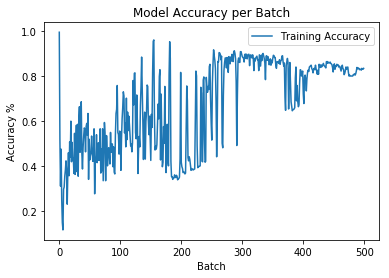

In [22]:
plt.plot(model_history, label="Training Accuracy")
plt.xlabel('Batch')
plt.ylabel('Accuracy %')
plt.title('Model Accuracy per Batch')
plt.legend(loc='best')

Game ended! Total reward: 10.0


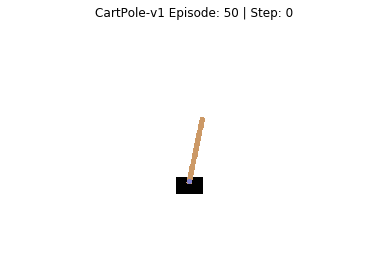

In [23]:
# Run: Play the environment to see how well it is doing based on the training above
episodes = 50 # should run for more episodes than this
time_per_episode=[]
for episode in range(1, episodes+1):
    observation = env.reset()
    obs = np.expand_dims(observation, axis=0)
    state = np.stack((obs, obs) , axis=1)
    done = False
    reward_total = 0.0
    action = 0
    info = None
    start = timeit.default_timer()
    while not done:
        show_state(env, episode, step=action)
        Q = model.predict(state)
        action = np.argmax(Q)
        observation, reward, done, info = env.step(action)
        obs = np.expand_dims(observation, axis=0)
        state = np.append(np.expand_dims(obs, axis=0), state[:, :1, :], axis=1)    
        reward_total += reward
    time_per_episode.append(timeit.default_timer() - start)

    
print('Game ended! Total reward: {}'.format(reward_total))

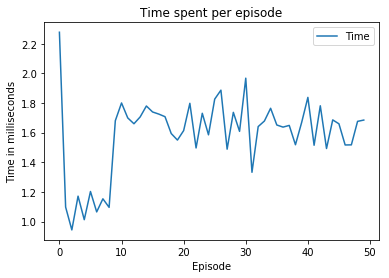

In [24]:
plt.plot(time_per_episode, label="Time")
plt.xlabel('Episode')
plt.ylabel('Time in milliseconds')
plt.title('Time spent per episode')
plt.legend(loc='best')

In [11]:
model.save_weights('basic_dqn_{}_weights.h5f'.format(env_name), overwrite=True)

Well, it seems to work. Probably training for more episodes might make the agent achieve its goal. So far, this model is good to work with environments which have _discrete_ action space.

Next, I am going to dig a little more on the implementation of various kinds of models.

<hr>
# Level 3: Using Keras-RL

I am going to use the Keras-rl library which has got implementations for reinforcement learning methods, one of which I implemented (Q-learning) in the previous level. This is to understand and explore more about what's going on under the hood.

Let's get started!

In [2]:
# Code adapted from: https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_cartpole.py
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

C:\Users\sahil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
envs = ['Acrobot-v1', 'CartPole-v1', 'MountainCar-v0']
env_num = 2
if not env_num > 3 and not env_num < 0:
    ENV_NAME = envs[env_num]

In [4]:
# Setup the environment
env = gym.make(ENV_NAME)
np.random.seed(0)
env.seed(0)

num_actions = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
# Build a model
model = Sequential()
model.add(Flatten(input_shape=(1,)+env.observation_space.shape))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_actions, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 643
Trainable params: 643
Non-trainable params: 0
_________________________________________________________________
None


It is important to know the different kinds of _Agent_ implementations. Here's a summary:

|Name|Action Space|
|----|------------|
|DQN |discrete|
|DDPG|continuous|
|NAF |continuous|
|CEM |discrete|
|SARSA|discrete|

For reference, I am going to list down all the policy implementations that Keras-RL provides:
* **LinearAnnealedPolicy**: computes a current threshold value and transfers it to an inner policy which chooses the action. The threshold value is following a linear function decreasing over time.
* **EpsGreedyQPolicy**: either takes a random action with probability epsilon or takes current best action with prob (1 - epsilon).
* **GreedyQPolicy**: returns the current best action according to q_values.
* **BoltzmannQPolicy**: builds a probability law on q values and returns an action selected randomly according to this law.
* **MaxBoltzmannQPolicy**: combination of the eps-greedy and Boltzman q-policy.
* **BoltzmannGumbelQPolicy**: Implements Boltzmann-Gumbel exploration (BGE) adapted for Q learning based on the paper Boltzmann Exploration Done Right (https://arxiv.org/pdf/1705.10257.pdf). BGE is invariant with respect to the mean of the rewards but not their variance. The parameter C, which defaults to 1, can be used to correct for this, and should be set to the least upper bound on the standard deviation of the rewards. BGE is only available for training, not testing. For testing purposes, you can achieve approximately the same result as BGE after training for N steps on K actions with parameter C by using the BoltzmannQPolicy and setting tau = C/sqrt(N/K).

In [6]:
# Configure and compile our agent
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions = num_actions, memory=memory, nb_steps_warmup = 15, 
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae', 'accuracy'])

In [8]:
# Time to learn something
dqn.fit(env, nb_steps=20000, visualize=False, verbose=1)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 0.492 - mean_absolute_error: 0.553 - acc: 0.467 - mean_q: 0.349

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: -1.0000
done, took 119.679 seconds


In [9]:
# Save the final weights after training
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

In [10]:
# Test the algorithm for 20 episodes
dqn.test(env, nb_episodes=20, visualize=True)

Testing for 20 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Episode 6: reward: -200.000, steps: 200
Episode 7: reward: -200.000, steps: 200
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: -200.000, steps: 200
Episode 10: reward: -200.000, steps: 200
Episode 11: reward: -200.000, steps: 200
Episode 12: reward: -200.000, steps: 200
Episode 13: reward: -200.000, steps: 200
Episode 14: reward: -200.000, steps: 200
Episode 15: reward: -200.000, steps: 200
Episode 16: reward: -200.000, steps: 200
Episode 17: reward: -200.000, steps: 200
Episode 18: reward: -200.000, steps: 200
Episode 19: reward: -200.000, steps: 200
Episode 20: reward: -200.000, steps: 200


# Conclusion

In this notebook, I explored the concept of _Reinforcement Learning_ by learning and implementing a basic Q-learning model on environments provided by Gym. I then moved on to creating a simple neural network to enhance the Q-function and apply it on a different environment, which delivered a decent performance. Further, I found a library called _Keral RL_ which consists of all the implementations of reinforcement learning and is easy to pull and build a model upon.

In my future work, I am going to take up a few 2-D games and try out a model to train an agent for playing them.
Do check out my website [here](http://www.sahiljohari.com/) and my work on Github (link on the website).